# PPL


In [2]:
import pymc3 as pm
import scipy.stats as stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 3.genenralized linear model : Poison regression model
- input : R
- output : 0 or natural number

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w2, w1]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8806257032946299, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


w1 1.003
w2 1.002


array([<Axes: title={'center': 'w1'}>, <Axes: title={'center': 'w2'}>],
      dtype=object)

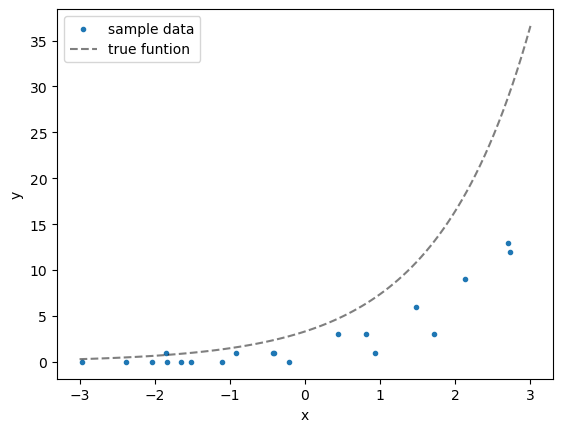

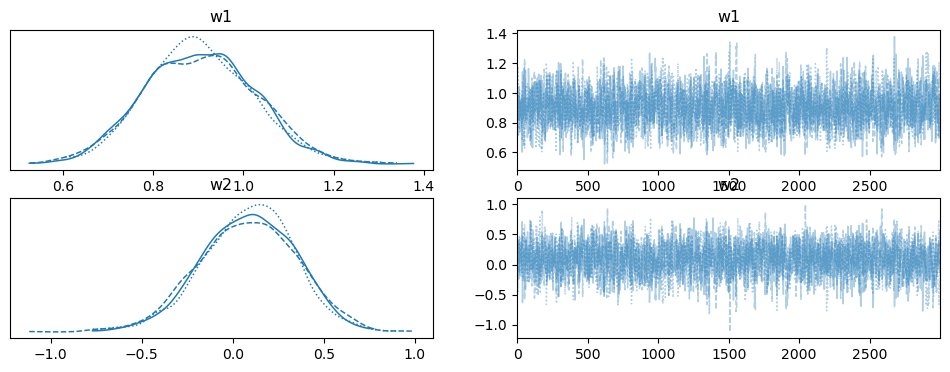

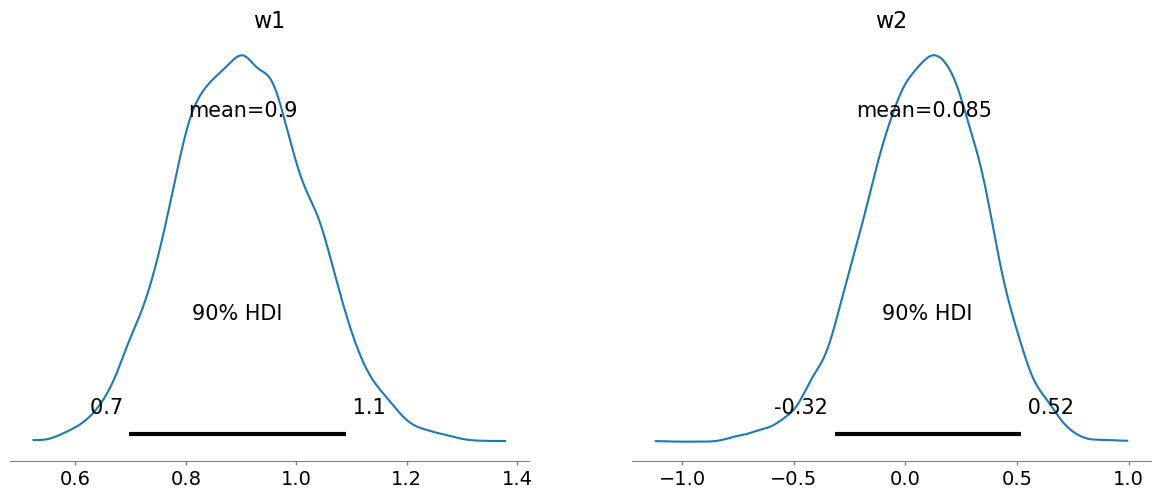

In [3]:
N = 20
true_w1 = 0.8
true_w2 = 1.2

x_data = np.random.uniform(-3,3,N)
y_data = stats.poisson(mu=np.exp(true_w1*x_data*true_w2)).rvs()

#plot data
x_plot_data = np.linspace(-3,3,100)
y_plot_data = stats.poisson(mu=np.exp(true_w1*x_plot_data+true_w2)).mean()
plt.scatter(x_data,y_data,marker=".",label="sample data")
plt.plot(x_plot_data,y_plot_data,label="true funtion",color="black",linestyle="--",alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

#model definition
with pm.Model() as model:
  x = pm.Data("x",x_data)
  w1 = pm.Normal("w1",mu=0.0,sigma=1.0)
  w2 = pm.Normal("w2",mu=0.0,sigma=1.0)
  y = pm.Poisson("y",mu=pm.math.exp(w1*x+w2),observed=y_data)

#inference with MCMC
with model:
  trace = pm.sample(draws=3000,tune=1000,chains=3,random_seed=1,return_inferencedata=True)

#check inference data
az.plot_trace(trace)
for var_info in az.rhat(trace).values():
  print(var_info.name,var_info.values.round(3),sep=" ")
az.plot_posterior(trace,hdi_prob=0.9)

### prediction

c:\Users\kawaw\anaconda3\envs\mypm3env\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


dict_keys(['y'])
(1000, 10)


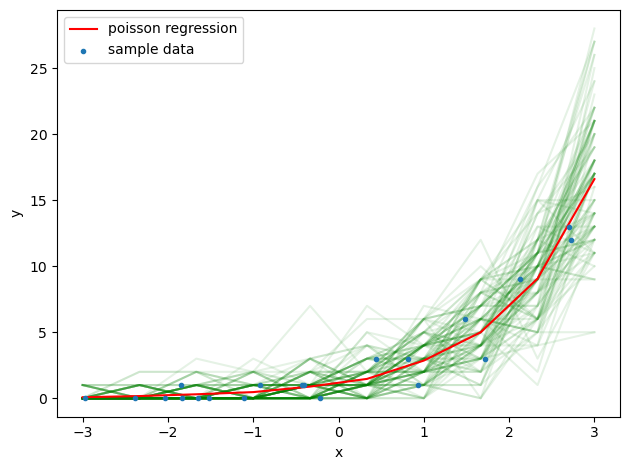

In [8]:
#validation data
x_new = np.linspace(-3,3,10)
with model:
    #set data
    pm.set_data({"x":x_new})
    #predict
    pred  = pm.sample_posterior_predictive(trace,samples=1000,random_seed=1)

print(pred.keys())
y_pred_samples = pred["y"]
print(y_pred_samples.shape)
#plot
for i in range(0,1000,10):
    plt.plot(x_new,y_pred_samples[i,:],alpha=0.1,zorder=i+1,color="green")
plt.plot(x_new,y_pred_samples.mean(axis=0),alpha=1.0,label="poisson regression",zorder=i+1,color="red")
plt.scatter(x_data,y_data,marker=".",label="sample data",zorder=i+2)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()

## 3.genenralized linear model : Logistic Regression model
- regression model : Bernoulli distribution -> classification
- input : R
- output : binary value {0,1}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8900418774101458, but should be close to 0.8. Try to increase the number of tuning steps.


w [1.001 1.    1.   ]


array([<Axes: title={'center': 'w\n0'}>, <Axes: title={'center': 'w\n1'}>,
       <Axes: title={'center': 'w\n2'}>], dtype=object)

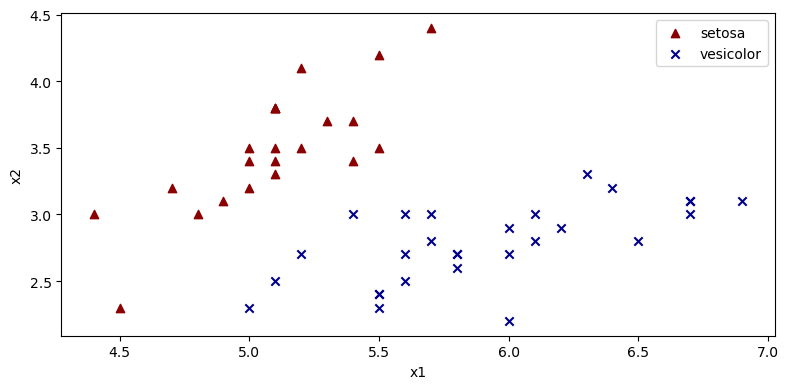

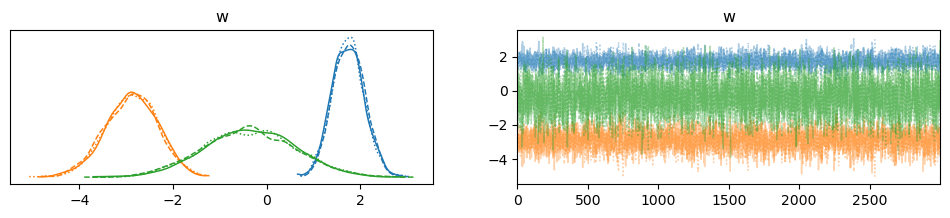

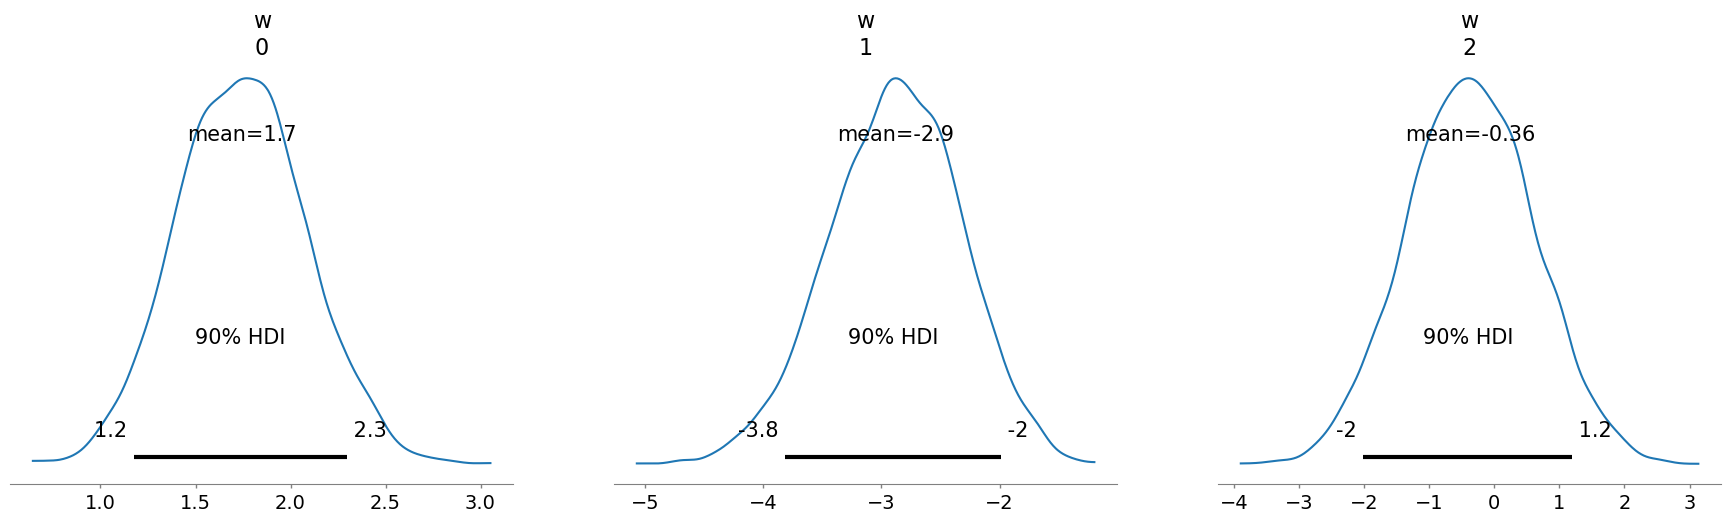

In [15]:
#load data : IRIS
iris_dataset = sns.load_dataset("iris")
#num of data 
N=50
#extract specific features
iris_dataset_2species = iris_dataset[iris_dataset["species"].isin(["setosa","versicolor"])].copy()

#sampling
iris_dataset_use = iris_dataset_2species.sample(N,random_state=1)
#variable
x_data = iris_dataset_use[["sepal_length","sepal_width"]].copy().values
#add bias
x_data_add_bias = np.concatenate([x_data,np.ones((N,1))],axis=1)
#print(x_data)
#goal variable
y_data = pd.Categorical(iris_dataset_use["species"]).codes
#print(y_data)
#visualize data
x_data_set = x_data[y_data==0]
x_data_ves = x_data[y_data==1]

fig,ax = plt.subplots(figsize=(8,4))
ax.scatter(x=x_data_set[:,0],y=x_data_set[:,1],color="darkred",marker="^",label="setosa")
ax.scatter(x=x_data_ves[:,0],y=x_data_ves[:,1],color="darkblue",marker="x",label="vesicolor")

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend()
plt.tight_layout()

#model setting
with pm.Model() as model:
    x = pm.Data("x",x_data_add_bias)
    w = pm.Normal("w",mu=0,sigma=1.0,shape=3)
    y = pm.Bernoulli("y",logit_p = w.dot(x.T),observed=y_data) #logit fucntion is used as a link function

with model:
    #inference by MCMC
    trace = pm.sample(draws=3000,tune=1000,chains=3,random_seed=1,return_inferencedata=True)

az.plot_trace(trace)
for var_info in az.rhat(trace).values():
    print(var_info.name,var_info.values.round(3),sep=" ")
az.plot_posterior(trace,hdi_prob=0.9)


### predict classification

C:\Users\kawaw\AppData\Local\Temp\ipykernel_21736\3240927872.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(10000, 2)


c:\Users\kawaw\anaconda3\envs\mypm3env\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


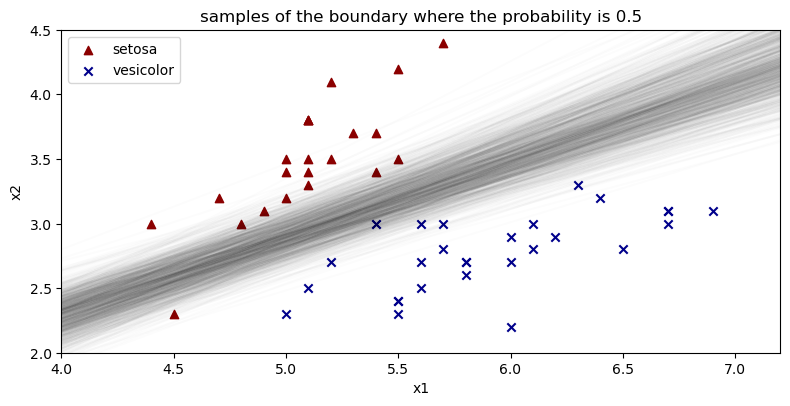

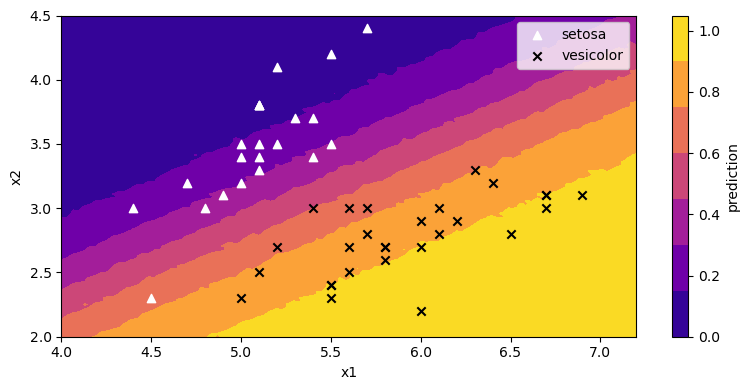

In [21]:
w_mcmc_samples = trace.posterior["w"].values.reshape(9000,3)

#for each dim
w1_samples = w_mcmc_samples[:,0]
w2_samples = w_mcmc_samples[:,1]
w3_samples = w_mcmc_samples[:,2] 

fig,ax = plt.subplots(figsize=(8,4))
#sample data
ax.scatter(x=x_data_set[:,0],y=x_data_set[:,1],color="darkred",marker="^",label="setosa")
ax.scatter(x=x_data_ves[:,0],y=x_data_ves[:,1],color="darkblue",marker="x",label="vesicolor")

N_new = 10
x1 = np.linspace(4,7.2,N_new)
for i in range(0,9000,10):
    #theta=0.5 with x1 and x2 
    x2 = -w3_samples[i] / w2_samples[i] - w1_samples[i]/w2_samples[i]*x1
    ax.plot(x1,x2,alpha=0.01,color="black")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend()
plt.tight_layout()
ax.set_xlim(4.0,7.2)
ax.set_ylim(2.0,4.5)
ax.set_title("samples of the boundary where the probability is 0.5")
fig.show()

#predictive distribution
## 2d grid
N_new = 100
x1_linspace = np.linspace(4.0,7.2,N_new)
x2_linspace = np.linspace(2.0,4.5,N_new)
x1_grid,x2_grid = np.meshgrid(x1_linspace,x2_linspace)
x_new = np.array([[x1,x2] for x1,x2 in zip(x1_grid.ravel(), x2_grid.ravel())])
print(x_new.shape)
x_new_add_bias = np.concatenate([x_new,np.ones((N_new**2,1))],axis=1) #[x1,x2,1]

with model:
    #validation data
    pm.set_data({"x":x_new_add_bias})
    #prediction
    pred = pm.sample_posterior_predictive(trace,samples=3000,random_seed=1)
y_pred_samples = pred["y"]

#plot
fig,ax = plt.subplots(figsize=(8,4))
#contour
contourf = ax.contourf(x1_grid,x2_grid,y_pred_samples.mean(axis=0).reshape(N_new,N_new),cmap="plasma")
#sample data
ax.scatter(x=x_data_set[:,0],y=x_data_set[:,1],color="white",marker="^",label="setosa")
ax.scatter(x=x_data_ves[:,0],y=x_data_ves[:,1],color="black",marker="x",label="vesicolor")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend()
cbar = fig.colorbar(contourf,ax=ax)
cbar.set_label("prediction")
cbar.set_ticks(ticks=np.arange(0,1.1,0.2))
plt.tight_layout()

## 5. Hierarchical Bayesian model
- infer hyperparameters by setting prior distribution
- considering difference of each group is possible

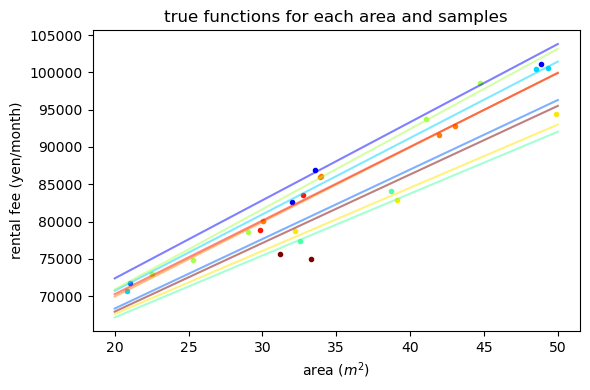

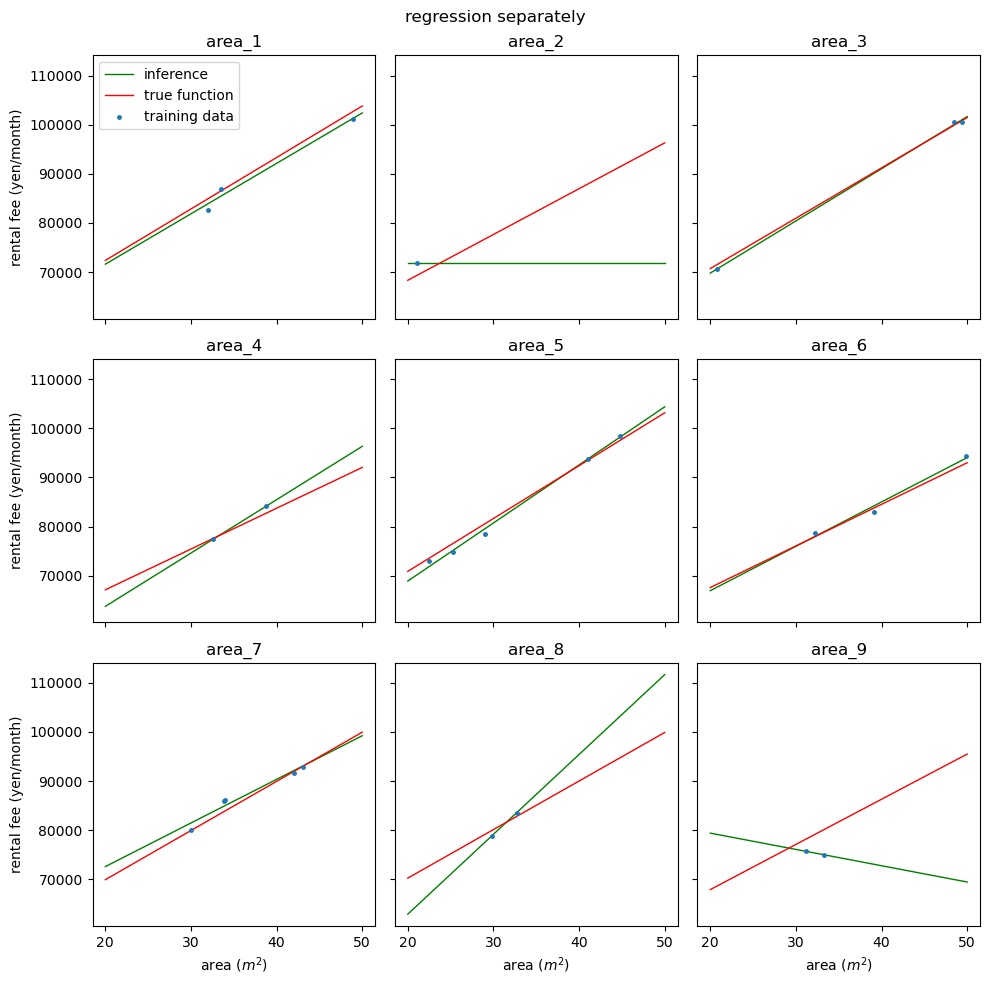

In [38]:
#load data
np.random.seed(12)
group_num = 9
data_num = 25

a_vector = np.random.normal(1000.0, scale=100.0, size=group_num)
b_vector = np.random.normal(50000.0, scale=500.0, size=group_num)

x_data = np.random.uniform(20, 50, data_num)

group_idx = np.random.randint(0, group_num, data_num)
y_data = a_vector[group_idx] * x_data + b_vector[group_idx] + np.random.normal(0, scale=1500.0, size=data_num)

x_data = np.append(x_data, 33.322)
y_data = np.append(y_data, 75004.54)
group_idx = np.append(group_idx, 8)

# # データ読み込み
#df_data = pd.read_csv('toy_data.csv')
# # 真の係数パラメータデータ
#df_coef = pd.read_csv('true_corf.csv')

df_data = pd.DataFrame([x_data, y_data, group_idx]).T
df_data.columns = ['x', 'y', 'systemID']

df_coef = pd.DataFrame([a_vector, b_vector]).T
df_coef.columns = ['a', 'b']

#variable setting
x_data = df_data["x"].values
#goal variables
y_data = df_data["y"].values
#group for each area
group_idx = df_data["systemID"].values.astype(int)
#gradient and bias for each area
a_vector,b_vector = df_coef["a"].values, df_coef["b"].values
#visualization
x_linspace = np.linspace(20,50,100)
fig,ax = plt.subplots(figsize=(6,4))
cm10 = plt.get_cmap("jet",10)
for i in range(9):
    #true funtion
    ax.plot(x_linspace,a_vector[i]*x_linspace+b_vector[i],color=cm10(i+1),alpha=0.5)
    #training data
    ax.scatter(x_data[group_idx==i],y_data[group_idx==i],marker=".",color=cm10(i+1))
ax.set_xlabel("area ($m^2$)")
ax.set_ylabel("rental fee (yen/month)")
ax.set_title("true functions for each area and samples")
plt.tight_layout()

#predict each data separately
fig,ax = plt.subplots(figsize=(10,10),ncols=3,nrows=3,sharex=True,sharey=True)
fig.suptitle("regression separately")
x_new = np.linspace(20,50,100)

for i in range(9):
    row_index=i//3
    col_index=i%3

    #extract data for each area
    x_i = x_data[group_idx==i]
    y_i = y_data[group_idx==i]
    #linear regression
    lr = LinearRegression()
    lr.fit(x_i.reshape(-1,1),y_i.reshape(-1,1))
    #visualization
    y_linear_model = lr.predict(x_new.reshape(-1,1))
    #print(y_linear_model.shape)
    #print(x_new.shape)
    ax[row_index,col_index].plot(x_new,y_linear_model,color="green",linewidth=1,label="inference")
    #true function
    y_true=a_vector[i]*x_linspace+b_vector[i]
    ax[row_index,col_index].plot(x_new,y_true,color="red",linewidth=1,label="true function")
    #training data
    ax[row_index,col_index].scatter(x_i,y_i,marker=".",s=25,zorder=2,label="training data")
    ax[row_index,col_index].set_title("area_{}".format(i+1))
    if row_index==2:
        ax[row_index,col_index].set_xlabel("area ($m^2$)")
    if col_index == 0:
        ax[row_index,col_index].set_ylabel("rental fee (yen/month)")
ax[0,0].legend()
plt.tight_layout()

### inference with bayesian modeling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [b_offset, b_sigma, b_mu, a_offset, a_sigma, a_mu]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 15 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 289 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5805756541673315, but should be close to 0.8. Try to increase the number of tuning steps.
There were 509 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5155041052605076, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


a_mu 1.033
a_offset [1.04  1.019 1.01  1.015 1.056 1.009 1.023 1.039 1.012]
b_mu 1.056
b_offset [1.044 1.051 1.016 1.057 1.021 1.053 1.026 1.053 1.064]
a_sigma 1.042
b_sigma 1.089


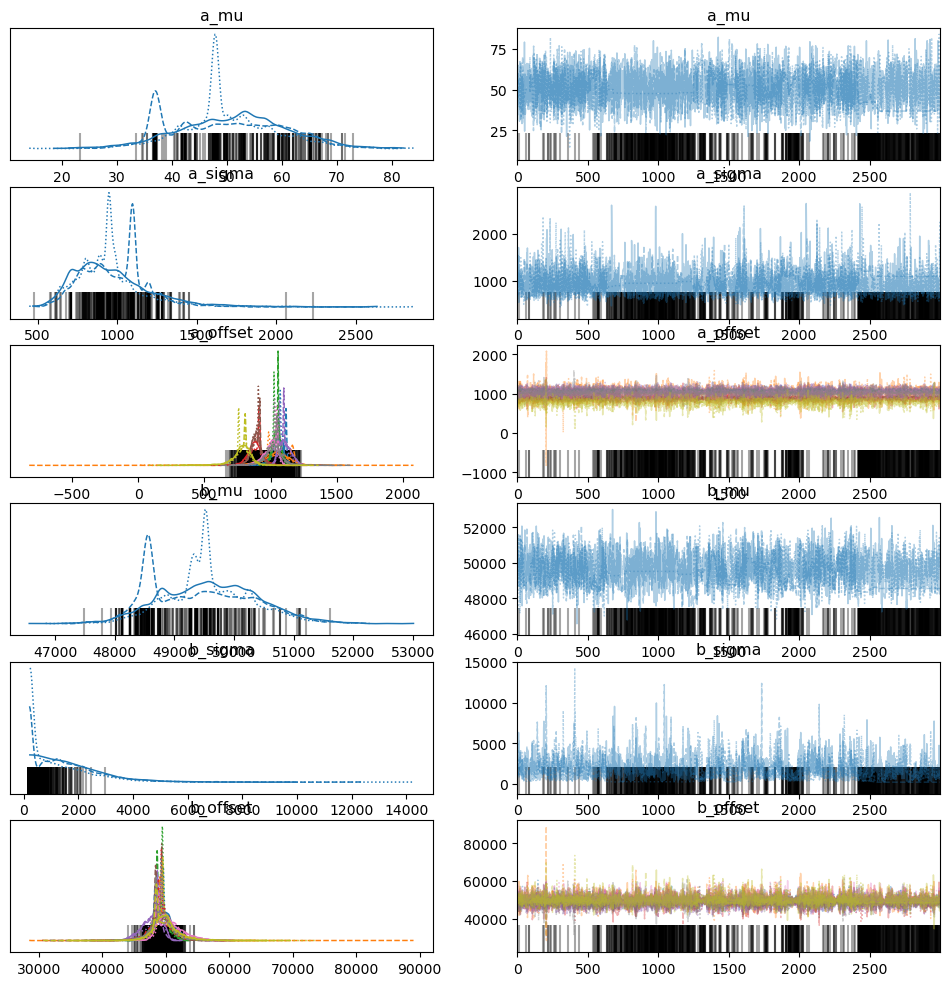

In [40]:
#model definition
with pm.Model() as model:
    x_shared = pm.Data("x",x_data)
    #prior distribution
    a_mu = pm.Normal("a_mu",mu=50,sigma=10)
    a_sigma=pm.HalfCauchy("a_sigma",beta=100)
    a_offset = pm.Normal("a_offset",mu=a_mu,sigma=a_sigma,shape=group_num)

    b_mu = pm.Normal("b_mu",mu=50000,sigma=1000)
    b_sigma = pm.HalfCauchy("b_sigma",beta=1000)
    b_offset=pm.Normal("b_offset",mu=b_mu,sigma=b_sigma,shape=group_num)
    
    #likelihood function
    y = pm.Normal("y",mu=a_offset[group_idx]*x_shared+b_offset[group_idx],sigma=1000,observed=y_data)

#inference
with model:
    trace = pm.sample(draws=3000,tune=1000,chains=3,random_seed=1,return_inferencedata=True)

az.plot_trace(trace,var_names=["a_mu","a_sigma","a_offset","b_mu","b_sigma","b_offset"])
for var_info in az.rhat(trace).values():
    print(var_info.name,var_info.values.round(3),sep=" ")

### prediction

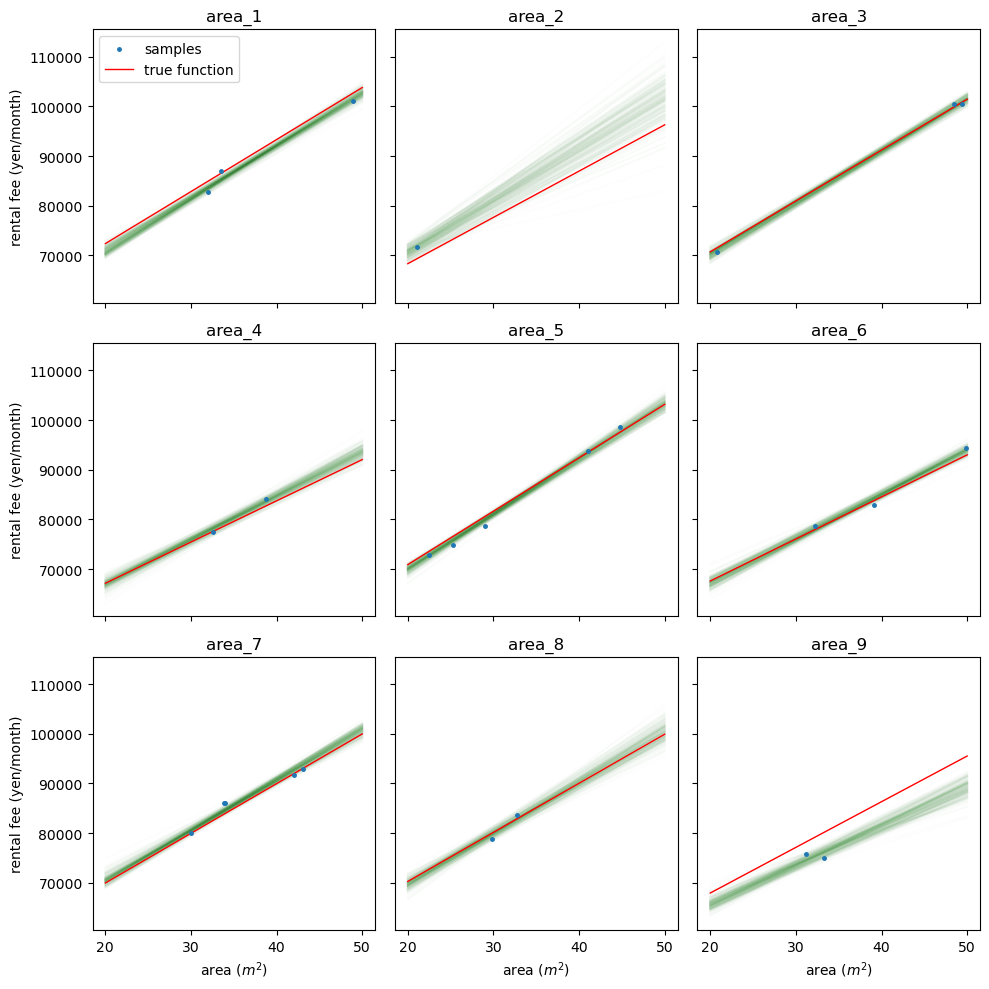

In [41]:
fig,ax = plt.subplots(figsize=(10,10),ncols=3,nrows=3,sharex=True,sharey=True)
x_new = np.linspace(20,50,100)

#for each area 
for i in range(9):
    row_index = i//3
    col_index = i%3

    #mean and std for each area
    a_i_mcmc_samples = trace.posterior["a_offset"][0,:,i]
    b_i_mcmc_samples = trace.posterior["b_offset"][0,:,i]

    #visualize training data
    x_i = x_data[group_idx==i]
    y_i = y_data[group_idx==i]
    ax[row_index,col_index].scatter(x_i,y_i,marker=".",zorder=3,s=25,label="samples")

    #visualize prediction values
    for k in range(0,3000,15):
        y_new_sample = a_i_mcmc_samples[k].values*x_new + b_i_mcmc_samples[k].values
        ax[row_index,col_index].plot(x_new,y_new_sample,alpha=0.01,color="green",zorder=1)
    
    #visualize true function
    y_true=a_vector[i]*x_linspace+b_vector[i]
    ax[row_index,col_index].plot(x_new,y_true,color="red",linewidth=1,label="true function")
    ax[row_index,col_index].set_title("area_{}".format(i+1))
    if row_index==2:
        ax[row_index,col_index].set_xlabel("area ($m^2$)")
    if col_index == 0:
        ax[row_index,col_index].set_ylabel("rental fee (yen/month)")
ax[0,0].legend()
plt.tight_layout()

### 6. Gaussian process regression model
- can consider abstract information

In [3]:
import torch
import gpytorch
from gpytorch.models import ExactGP

### Define Gaussian process regression model

Text(0, 0.5, '$y$')

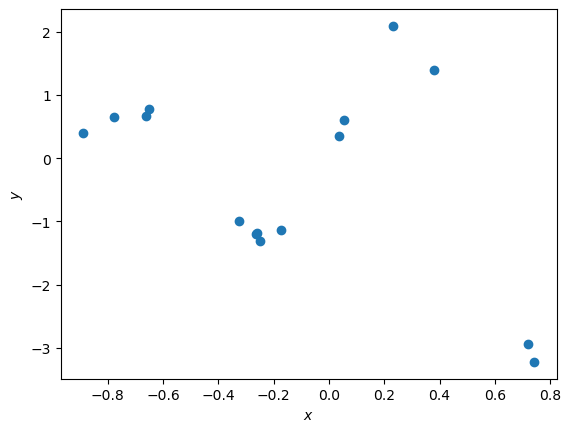

In [45]:
#num of data
N = 15
x_data = torch.FloatTensor(N).uniform_(-1,1)
def true_function(x):
    return 1.5*torch.exp(x)*torch.sin(2*torch.pi*x)

y_data = true_function(x_data)+0.1*torch.randn(N)
plt.scatter(x_data,y_data)
plt.xlabel("$x$")
plt.ylabel("$y$")

In [49]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self,train_x,train_y,likelihood):
        super(ExactGPModel,self).__init__(train_x,train_y,likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        #kernel function
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)
    
#likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_data,y_data,likelihood)

### training

Text(0, 0.5, 'loss')

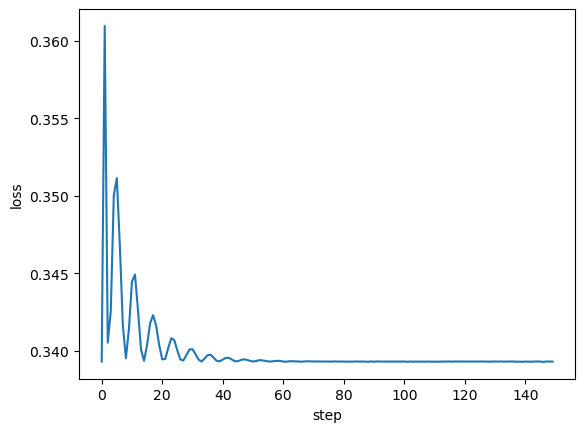

In [52]:
#train mode
model.train()
likelihood.train()

#optimizer 
optimizer = torch.optim.Adam(model.parameters(),lr=0.1)
#marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,model)

training_iter=150
loss_list = []
for i in range(training_iter):
    #init gradients as 0
    optimizer.zero_grad()
    #output
    output = model(x_data)
    #calculate loss
    loss = -mll(output,y_data)
    #backward loss and calculate gradient
    loss.backward()
    #modify weights
    optimizer.step()
    loss_list.append(loss.detach().numpy())

#print(loss_list)
plt.plot(loss_list)
plt.xlabel("step")
plt.ylabel("loss")

### predction

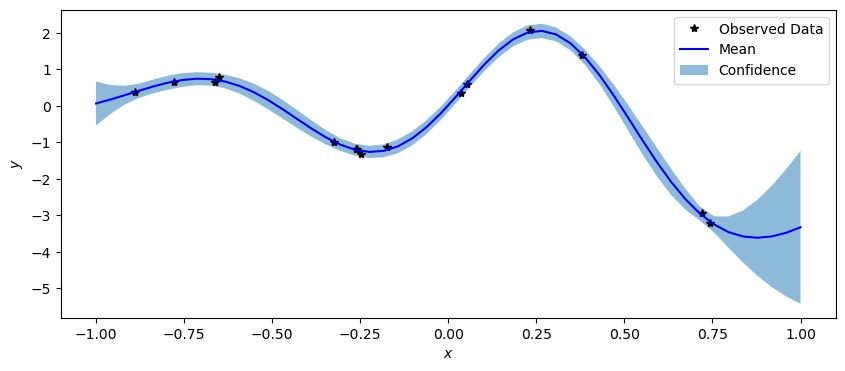

In [60]:
#inference mode
model.eval()
likelihood.eval()

#test data
x_new = torch.linspace(-1,1,50)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #outpus predictive distribution
    prediction = likelihood(model(x_new))
    #trust region
    lower,upper = prediction.confidence_region()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', label='Observed Data')
ax.plot(x_new.numpy(), prediction.mean.numpy(), 'b', label='Mean')
ax.fill_between(x_new.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend()

## 7. Gaussian process Regression model : generalize likelihood function
- p(y|f) ~ Bernoulli(y|sigmoid(f)) : y={0,1} binary classification 
- p(y|f) ~ Poisson(y|exp(f)) : y=Natural number including 0 : regression model 
- Here :: using Bernoulli distribution -> binary classification

### make samples

C:\Users\kawaw\AppData\Local\Temp\ipykernel_21496\3575269366.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  f = np.random.multivariate_normal(mean=np.zeros(grid_N**2),cov=K)


Text(0.5, 1.0, 'true function and samples')

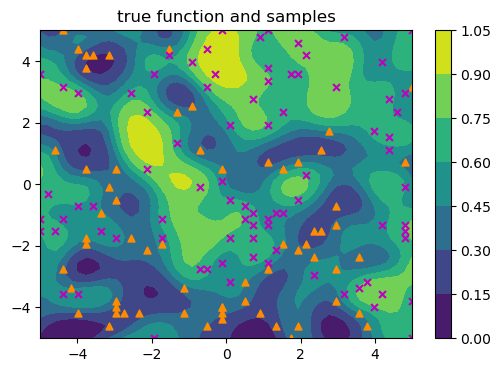

In [9]:
grid_N = 50
x = np.linspace(-5,5,grid_N)
x1_grid,x2_grid = np.meshgrid(x,x)
x12_grid = np.array([[x1,x2] for x1,x2 in zip(x1_grid.ravel(), x2_grid.ravel())])
x12_grid = torch.from_numpy(x12_grid).float()

#generate data with GP
kernel = gpytorch.kernels.RBFKernel()
K = kernel.forward(x12_grid,x12_grid).detach().numpy()
f = np.random.multivariate_normal(mean=np.zeros(grid_N**2),cov=K)

#sigmoid function
sigmoid = lambda x:1/(1+np.exp(-x))
Y = sigmoid(f)
Y_grid = Y.reshape(grid_N,grid_N)

#binarize
threshold = lambda x: 1 if x>=0.5 else 0
Y_binary_grid = torch.tensor(list(map(threshold,Y)))

#sampling
N=150
sample_index = np.random.choice(np.arange(grid_N**2),N)
x_data = x12_grid[sample_index].clone().float()
y_data = Y_binary_grid[sample_index].clone().float()

fig,ax = plt.subplots(figsize=(6,4))
image = ax.contourf(x1_grid,x2_grid,Y_grid)

#plot samples
x_data_1 = x_data[y_data==0]
x_data_2 = x_data[y_data==1]

ax.scatter(x=x_data_1[:,0],y=x_data_1[:,1],color="darkorange",marker="^",s=25)
ax.scatter(x=x_data_2[:,0],y=x_data_2[:,1],color="m",marker="x",s=25)
plt.colorbar(image)
ax.set_title("true function and samples")

### GP with variational inference

#### model setting

In [10]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, UnwhitenedVariationalStrategy

#GP Classification model
class GPClassificationModel(ApproximateGP):
    def __init__(self,train_x):
        #set variational approximate function around induced points
        variational_distribution  = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(self,train_x,variational_distribution,learn_inducing_locations=False)
        super(GPClassificationModel,self).__init__(variational_strategy)
        #mean function
        self.mean_module = gpytorch.means.ConstantMean()
        #kernel function
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(2))
    
    #generative process in GP
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x,covar_x)
        return latent_pred

#model definition
model = GPClassificationModel(x_data)
#likelihood function : Bernoulli distribution
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

#### training

Text(0, 0.5, 'Loss')

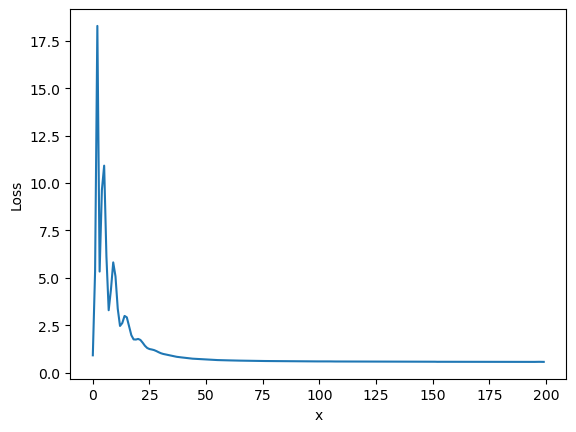

In [12]:
#training mode
model.train()
likelihood.train()

#set hyperparameters of kernel <- prevent overfitting
model.covar_module.base_kernel.lengthscale = torch.tensor([0.6931,0.6931])
"""
in an RBF (Radial Basis Function) kernel, the lengthscale parameter determines 
how quickly the correlation between function values decreases as the input points move apart.
"""
#limit the parameters to be optimized
all_params = set(model.parameters())
fix_params = {model.covar_module.base_kernel.raw_lengthscale}
opt_params = list(all_params-fix_params)

#set optimizer as Adam
optimizer = torch.optim.Adam(opt_params,lr=0.1)
#set ELBO for Loss
mll = gpytorch.mlls.VariationalELBO(likelihood,model,y_data.numel()) #data.numel() -> numel : num of elements

training_iter = 200
loss_list = []
for i in range(training_iter):
    #init gradients of optimizer
    optimizer.zero_grad()
    #output
    output = model(x_data)
    #calculate loss and gradients
    loss = -mll(output,y_data)
    loss.backward()
    loss_list.append(loss.detach().numpy())
    #update weights
    optimizer.step()

plt.plot(loss_list)
plt.xlabel("x")
plt.ylabel("Loss")

#### Inference

tensor([[ 2.1755e+00,  2.0655e+00,  1.7898e+00,  ...,  6.9290e-07,
          1.0556e-07, -1.8342e-07],
        [ 2.0655e+00,  2.1356e+00,  2.0160e+00,  ...,  1.3468e-06,
          2.6167e-07, -2.9985e-07],
        [ 1.7898e+00,  2.0160e+00,  2.0749e+00,  ...,  2.2663e-06,
          5.9418e-07, -3.0371e-07],
        ...,
        [ 6.9290e-07,  1.3468e-06,  2.2663e-06,  ...,  1.5052e+00,
          1.3378e+00,  1.0617e+00],
        [ 1.0556e-07,  2.6167e-07,  5.9418e-07,  ...,  1.3378e+00,
          1.3394e+00,  1.2182e+00],
        [-1.8342e-07, -2.9985e-07, -3.0371e-07,  ...,  1.0617e+00,
          1.2182e+00,  1.2787e+00]])


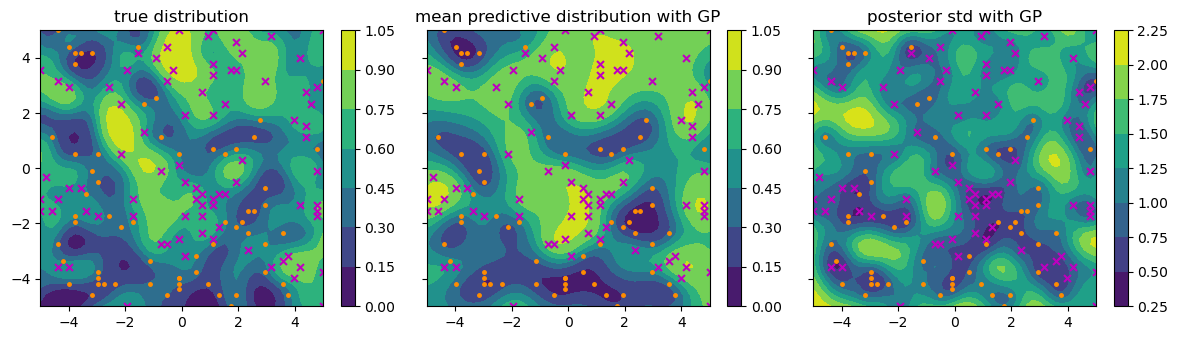

In [19]:
#inference mode
model.eval()
likelihood.eval()

with torch.no_grad():
    #output predictive distribution
    f_dist = model(x12_grid)
    #mean of predictive distribution
    mean = f_dist.mean
    #trust region
    f_lower, f_upper = f_dist.confidence_region()
    #likelihood
    y_dist = likelihood(f_dist)

print(f_dist.covariance_matrix)
fig,ax = plt.subplots(figsize=(12,3.5),ncols=3,sharex=True,sharey=True)
#true contours
image1 = ax[0].contourf(x1_grid,x2_grid,Y_grid)
#mean of predictive distribution
image2 = ax[1].contourf(x1_grid,x2_grid,y_dist.mean.numpy().reshape(grid_N,grid_N))
#diagonals of covariance matrix of predictive distribution
image3 = ax[2].contourf(x1_grid,x2_grid,f_dist.covariance_matrix.diag().detach().numpy().reshape(grid_N,grid_N))

for i in  range(3):
    ax[i].scatter(x=x_data_1[:,0],y=x_data_1[:,1],color="darkorange",marker=".",s=25)
    ax[i].scatter(x=x_data_2[:,0],y=x_data_2[:,1],color="m",marker="x",s=25)
ax[0].set_title("true distribution")
ax[1].set_title("mean predictive distribution with GP")
ax[2].set_title("posterior std with GP")
plt.colorbar(image1,ax=ax[0])
plt.colorbar(image2,ax=ax[1])
plt.colorbar(image3,ax=ax[2])
plt.tight_layout()